# TP1 — Streaming & Count-Min Sketch 
#### Etudiant : AKLI Melissa

#### Objectifs
- Comprendre le fonctionnement de Kafka (producer/consumer)
- Implémenter un Count-Min Sketch
- Détecter des heavy hitters en streaming


##  Partie 1 — Préparation environnement


### Vérifier Python et l'environnement

In [1]:
import sys, platform
print("Python:", sys.version)
print("Executable:", sys.executable)
print("Platform:", platform.platform())

Python: 3.11.8 (main, May 14 2025, 23:43:50) [GCC 13.3.0]
Executable: /home/mel/.pyenv/versions/3.11.8/bin/python
Platform: Linux-5.15.167.4-microsoft-standard-WSL2-x86_64-with-glibc2.39


### Vérifier l'installation Kafka

In [2]:
import kafka
print("kafka-python version:", kafka.__version__)
print("kafka module path:", kafka.__file__)

kafka-python version: 2.3.0
kafka module path: /home/mel/.pyenv/versions/3.11.8/lib/python3.11/site-packages/kafka/__init__.py


In [3]:
import socket

def check_port(host: str, port: int, timeout: float = 1.0) -> bool:
    s = socket.socket()
    s.settimeout(timeout)
    try:
        s.connect((host, port))
        return True
    except Exception as e:
        print(f"Cannot connect to {host}:{port} -> {e}")
        return False
    finally:
        s.close()

print("Kafka port 9092 open:", check_port("localhost", 9092))
print("Zookeeper port 2181 open:", check_port("localhost", 2181))

Kafka port 9092 open: True
Zookeeper port 2181 open: True


### Test de connexion Kafka

In [4]:
from kafka import KafkaProducer
import json, time

BOOTSTRAP = "localhost:9092"
TOPIC = "hashtag_stream"

producer = KafkaProducer(
    bootstrap_servers=BOOTSTRAP,
    value_serializer=lambda v: json.dumps(v).encode("utf-8"),
    request_timeout_ms=3000,
    api_version_auto_timeout_ms=3000,
    max_block_ms=3000,
    acks="all",
)

future = producer.send(TOPIC, {"tag": "#test", "ts": time.time()})
metadata = future.get(timeout=5)  # force une réponse ou une erreur claire

producer.flush()
producer.close()

print("Connexion Kafka OK — message envoyé")
print("Metadata:", metadata)


Connexion Kafka OK — message envoyé
Metadata: RecordMetadata(topic='hashtag_stream', partition=0, topic_partition=TopicPartition(topic='hashtag_stream', partition=0), offset=5688, timestamp=1767718126906, checksum=None, serialized_key_size=-1, serialized_value_size=42, serialized_header_size=-1)


### Test Consumer

In [5]:
from kafka import KafkaConsumer
import json

consumer = KafkaConsumer(
    TOPIC,
    bootstrap_servers=BOOTSTRAP,
    auto_offset_reset="latest",
    enable_auto_commit=False,
    value_deserializer=lambda v: json.loads(v.decode("utf-8")),
    consumer_timeout_ms=5000,  # stop si rien au bout de 5s
)

print(" Consumer lancé, attente d'un message (5s max)...")
msgs = list(consumer)
consumer.close()

print(f"Messages lus: {len(msgs)}")
if msgs:
    print("Exemple:", msgs[-1].value)
else:
    print(" Aucun message lu ( ok si aucun producer ne tourne au même moment).")


 Consumer lancé, attente d'un message (5s max)...
Messages lus: 0
 Aucun message lu ( ok si aucun producer ne tourne au même moment).


##  Partie 2 — Implémentation du Count-Min Sketch

In [6]:
import numpy as np
import hashlib

class CountMinSketch:
    def __init__(self, d=5, w=1000):
        """
        d : profondeur (nombre de fonctions de hachage)
        w : largeur (nombre de colonnes par ligne)
        """
        self.d = d
        self.w = w
        # Table de comptage : d lignes, w colonnes
        self.table = np.zeros((d, w), dtype=np.int64)

    def _hash(self, x, i):
        """
        Hachage déterministe : mappe (x, i) -> [0, w-1]
        On concatène x avec i pour obtenir d fonctions de hachage "différentes".
        """
        s = f"{x}_{i}".encode("utf-8")
        h = hashlib.md5(s).hexdigest()
        return int(h, 16) % self.w

    def update(self, x):
        """
        Ajoute une occurrence de x :
        on incrémente un compteur par ligne.
        """
        for i in range(self.d):
            j = self._hash(x, i)
            self.table[i, j] += 1

    def estimate(self, x):
        """
        Estime la fréquence de x :
        min des compteurs correspondants (propriété CMS).
        """
        return min(self.table[i, self._hash(x, i)] for i in range(self.d))


In [7]:
#Test 
# 1) fréquences contrôlées
true_freq = {
    "#ai": 100,
    "#data": 50,
    "#stream": 10,
}

# 2) création CMS (tu peux jouer sur w pour provoquer plus/moins de collisions)
cms = CountMinSketch(d=5, w=100)

# insertion des occurrences contrôlées
for tag, n in true_freq.items():
    for _ in range(n):
        cms.update(tag)

# 3) estimation + erreurs
print("Hashtag | True | Est | AbsError | RelError")
print("-" * 45)

for tag, f_true in true_freq.items():
    f_est = cms.estimate(tag)

    abs_error = abs(f_est - f_true)
    rel_error = abs_error / f_true if f_true > 0 else 0.0

    print(f"{tag:7} | {f_true:4d} | {f_est:3d} | {abs_error:8d} | {rel_error:.3f}")

Hashtag | True | Est | AbsError | RelError
---------------------------------------------
#ai     |  100 | 100 |        0 | 0.000
#data   |   50 |  50 |        0 | 0.000
#stream |   10 |  10 |        0 | 0.000


## Partie 3 — Kafka Producer

In [8]:
from kafka import KafkaProducer
import json, random, time

TOPIC = "hashtag_stream"
hashtags = ["#ai", "#ml", "#data", "#python", "#stream"]

producer = KafkaProducer(
    bootstrap_servers=["localhost:9092"],
    value_serializer=lambda v: json.dumps(v).encode("utf-8")
)

MAX_MESSAGES = 500
count = 0

print(f"Producing messages to topic '{TOPIC}'...")

try:
    while count < MAX_MESSAGES:
        msg = {"tag": random.choice(hashtags), "ts": time.time()}
        producer.send(TOPIC, value=msg)
        count += 1
        time.sleep(0.1)

except KeyboardInterrupt:
    print("Producer interrupted by user.")

finally:
    producer.flush()
    producer.close()
    print(f"Producer stopped after {count} messages")

Producing messages to topic 'hashtag_stream'...
Producer stopped after 500 messages


##  Partie 4 — Kafka Consumer + CMS

In [12]:
from kafka import KafkaConsumer
import json

TOPIC = "hashtag_stream"
THRESHOLD = 100
MAX_MESSAGES = 500

cms = CountMinSketch()
heavy_hitters = set()
total = 0

consumer = KafkaConsumer(
    TOPIC,
    bootstrap_servers=["localhost:9092"],
    auto_offset_reset="earliest",
    enable_auto_commit=True,
    value_deserializer=lambda v: json.loads(v.decode("utf-8")),
)

print(f"Consuming from '{TOPIC}'...")

try:
    for msg in consumer:
        tag = msg.value.get("tag")
        if tag is None:
            continue

        total += 1
        cms.update(tag)
        est = cms.estimate(tag)

        if est >= THRESHOLD and tag not in heavy_hitters:
            heavy_hitters.add(tag)
            pct = 100.0 * est / max(total, 1)
            print(f"[HEAVY HITTER] {tag} ~ {est} ({pct:.2f}%)")

        if total >= MAX_MESSAGES:
            break

except KeyboardInterrupt:
    print("Consumer interrupted by user.")

finally:
    consumer.close()
    print(f" Consumer stopped after {total} messages")

Consuming from 'hashtag_stream'...
[HEAVY HITTER] #ml ~ 100 (23.42%)
[HEAVY HITTER] #python ~ 100 (21.14%)
[HEAVY HITTER] #stream ~ 100 (20.24%)
 Consumer stopped after 500 messages


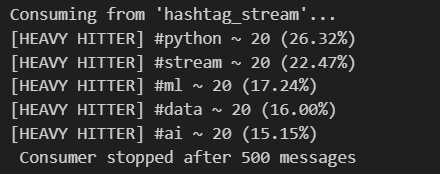

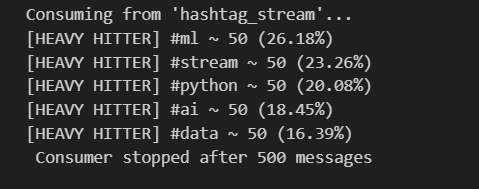

### Analyse des résultats 
Les expérimentations ont été réalisées avec trois valeurs différentes du paramètre THRESHOLD (20, 50 et 100), tout en conservant le même flux de données et le même nombre total de messages consommés (500).

Pour **THRESHOLD = 100**, seuls les hashtags atteignant une fréquence estimée d’environ 100 sont détectés comme heavy hitters.  
La détection intervient donc plus tard dans le flux et concerne uniquement les hashtags les plus fréquents.

Pour **THRESHOLD = 50**, les heavy hitters sont détectés plus tôt.  
L’ensemble des hashtags du flux dépasse progressivement ce seuil, ce qui entraîne l’apparition de plusieurs alertes `[HEAVY HITTER]`.

Pour **THRESHOLD = 20**, la détection est encore plus rapide.  
Tous les hashtags sont identifiés comme heavy hitters très tôt dans le flux, ce qui augmente la sensibilité du système mais réduit la sélectivité.

Ces résultats montrent que le choix du paramètre THRESHOLD permet d’ajuster le compromis entre rapidité de détection et sélectivité des heavy hitters.

Un seuil faible favorise une détection précoce mais génère davantage d’alertes, tandis qu’un seuil élevé cible uniquement les éléments les plus fréquents du flux.  
Le Count-Min Sketch se révèle ainsi particulièrement adapté à la détection de heavy hitters en streaming avec une mémoire bornée.



##  Partie 5 — Questions théoriques

### Q1 —  Expliquez en une phrase le rôle de Kafka dans ce pipeline de streaming.?
Réponse :
Kafka joue le rôle de système de messagerie distribué permettant de transporter de manière fiable et scalable le flux de données temps réel entre le producteur et le consommateur.

### Q2 —  Pourquoi utilise-t-on Docker ici plutôt qu’une installation locale “manuelle” de Kafka et Zookeeper? Citez au moins deux avantages concrets (ex. déploiement, reproductibilité, isolation).
Réponse:
Docker permet un déploiement rapide et reproductible de Kafka et Zookeeper sans dépendances locales, tout en assurant une isolation des services et une configuration identique sur toutes les machines.

### Q3 —  En observant le flux généré, quels hashtags semblent apparaître le plus souvent? Comment pourriez-vous vérifier cette intuition de manière programmatique (même sans CMS)?
Réponse :
Les hashtags #ai, #ml, #data, #python et #stream apparaissent avec des fréquences similaires, car ils sont sélectionnés aléatoirement et de manière uniforme par le producteur.
Cette intuition peut être vérifiée en comptant les occurrences exactes via un dictionnaire Python (dict ou collections.Counter) côté consommateur.

### Q4 —  Modifiez time.sleep(0.1) en time.sleep(0.01). Expliquez l’impact attendu sur : la cadence d’envoi des messages; la charge sur le broker Kafka;la difficulté de traitement côté consommateur.
Réponse : 
La cadence d’envoi des messages est multipliée par dix, ce qui augmente fortement la charge sur le broker Kafka et rend le traitement côté consommateur plus exigeant en termes de performance et de latence.

### Q5 — Justifiez la phrase suivante : “Le Count-Min Sketch peut surestimer la fréquence d’un élément, mais ne peut jamais la sous-estimer.”
Réponse : 
Chaque compteur du Count-Min Sketch contient la fréquence réelle d’un élément augmentée d’éventuelles collisions dues au hachage, et l’estimation finale étant le minimum de ces compteurs, elle ne peut jamais être inférieure à la fréquence réelle.

### Q6 — Comment les paramètres d (nombre de lignes) et w (largeur) influencent-ils : la probabilité de collisions; la mémoire utilisée; la précision des estimations? Proposez qualitativement comment choisir d et w pour un budget mémoire donné.
Réponse :

Un w plus grand réduit la probabilité de collisions mais augmente la mémoire utilisée.

Un d plus grand améliore la précision en réduisant l’impact des collisions via le minimum, au prix d’une mémoire supplémentaire.

Pour un budget mémoire donné, on choisit w suffisamment grand pour limiter les collisions et d modéré pour assurer une bonne robustesse statistique sans surcoût excessif.

### Q7 — Que se passe-t-il lorsque le seuil THRESHOLD est :trop bas (ex. 5); trop haut (ex. 500)? Discutez le compromis entre bruit (faux positifs) et risque de rater des heavy hitters.
Réponse :
Un seuil trop bas génère beaucoup de faux positifs (bruit), tandis qu’un seuil trop élevé retarde la détection et peut faire manquer certains heavy hitters.
Il existe donc un compromis entre sensibilité et sélectivité dans le choix du seuil.

### Q8 — Dans un système de production, pourquoi un seuil relatif (par exemple “éléments dontla fréquence est > 1% du flux”) peut-il être plus pertinent qu’un seuil absolu? Donnez au moins un cas d’usage concret (monitoring, détection d’anomalies, etc.)
Réponse :
Un seuil relatif s’adapte automatiquement au volume du flux, ce qui le rend plus robuste aux variations de charge.
Par exemple, en monitoring applicatif, détecter des événements représentant plus de 1 % du trafic permet d’identifier des anomalies même lorsque le volume total varie fortement.

##  Partie 6 — Questions de synthèse

### Quels sont les avantages et limites d’un CMS par rapport à un comptage exact en mémoire?
Le Count-Min Sketch permet d’estimer les fréquences avec une mémoire bornée et indépendante de la taille du flux, ce qui le rend particulièrement adapté aux flux massifs et continus.
En revanche, contrairement à un comptage exact, il introduit une approximation due aux collisions de hachage, ce qui peut entraîner une surestimation des fréquences et empêche l’obtention de valeurs exactes.

###  Comment ce TP se généralise-t-il à des flux à très fort volume (ordre du million d’événements par seconde)?
Ce TP se généralise naturellement à des flux de très grand volume en exploitant le caractère streaming et incrémental du Count-Min Sketch, dont la complexité par événement est constante.
Dans un contexte industriel, Kafka permet de répartir la charge via des partitions et plusieurs consommateurs parallèles, tandis que le CMS garantit un traitement temps réel avec une mémoire et un temps de calcul maîtrisés, même à très haut débit.